# Community Model
We want to combine all 7 bacterial species into one big community model, where bacteria exchange metabolites. This is important to analyse how they interact which each other reagrding e.g. cross-feeding

# Imports and Load Individual Models

In [1]:
# basic
import pandas as pd
import numpy as np
import os
import re
# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis, pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from micom import Community
from micom.workflows import tradeoff
# plot
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from pyvis.network import Network

In [171]:
# Ändert das Anzeigeformat der Gleitkommazahlen
pd.options.display.float_format = '{:.5f}'.format

In [2]:
# Load SBML Models
models_path = "../Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [ ]:
# Load well established models for compariso
ecoli = read_sbml_model("../Models/iML1515.xml")
ecoli.solver = "cplex"
pseudo = read_sbml_model("../Models/iJN1463.xml")
pseudo.solver = "cplex"

In [ ]:
def get_amounts(model):
    rxns = len(model.reactions)
    mets = len(model.metabolites)
    print(f"{model.id} has {rxns} reactions and {mets} metabolites")

In [ ]:
for model in models.values():
    get_amounts(model)

# Functions

In [34]:
def safe_parse(x):
    if x.startswith('['):
        # Add quotes around items inside brackets if they're not already quoted
        items = re.findall(r'\w+__?\w*', x)
        return items
    else:
        return x

# change medium
def change_medium(model, medium_dict):
    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    if model.id == "C7":
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium_dict.items()}

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)


# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict, frac=1):
    with model:
        change_medium(model, medium_dict)
        try:
            #print(model.medium)
            if model.id != "C7":
                solution = pfba(model)
                growth = solution.fluxes["Growth"]
            else:
                solution = model.cooperative_tradeoff(fluxes=True, pfba=True, fraction=frac).fluxes.transpose()
                growth = solution[solution.index.str.contains("Growth")].transpose()
                growth = growth[~ growth.index.str.contains("medium")]
                growth.index.name = "model"
                growth = growth["Growth"]
            return growth
        except Infeasible:
            #print(f"Model {model.id} is infeasible with the given medium.")
            return None
        except OptimizationError as e:
            #print(f"OptimizationError for model {model.id}: {e}")
            return None


# takes result dict from "create medium" to create a heatmap
def visualise_heatmap_medium(results):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame(results).T  # Transpose the DataFrame

    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
    plt.title("Growth Values Heatmap")
    plt.xlabel("Model ID")
    plt.ylabel("Carbon Source")
    plt.show()


# takes a list with different carbon sources (EX reactions) and a list with reactions that together form a minimal medium
# each carbon source is coupled with the minimal medium one at the time and these media are then testes for growth
# model_dict contain the models where the media are tested on;
# it is visualised through a heatmap
def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):
    # Flatten the carbon_list for consistent keys
    flattened_sources = [item[0] if isinstance(item, list) else item for item in carbon_list]
    results = {carbon[3:-2]: {model.id: None for model in model_dict.values()} for carbon in flattened_sources}

    for carbon in carbon_list:
        # Standardize the carbon key (used to index the results dict)
        if isinstance(carbon, list):
            carbon_key = carbon[0][3:-2]
            new_medium = minimal_list + carbon
        else:
            carbon_key = carbon[3:-2]
            new_medium = minimal_list + [carbon]

        # define uptake bound here (this has big impact on how much biomass can be produced)
        # med_dict = {new_medium[i]: medium_uptake_bound for i in range(len(new_medium))}

        #####
        if carbon_only:
            carbon_sources = carbon if isinstance(carbon, list) else [carbon]
            med_dict = {
                met: medium_uptake_bound if met in carbon_sources else 1000
                for met in new_medium}
        else:
            med_dict = {met: medium_uptake_bound for met in new_medium}
        #####

        for model in model_dict.values():
            growth_val = test_medium(model, med_dict)
            if isinstance(growth_val, pd.Series) and growth_val is not None:
                #print(carbon, growth_val)
                #growth_val = sum(pd.DataFrame(growth_val)["fluxes"])/7
                growth_val= pd.DataFrame(growth_val).iloc[:, 0].sum()/7
            results[carbon_key][model.id] = growth_val
        #print("-----")

    visualise_heatmap_medium(results)

# Create Community Model
we want to combine our 7 models into one; they'll share one compartment where they can exchange metabolites.

In [20]:
for model in models.values():
    model.reactions.ATPM.lower_bound = 1
    model.reactions.ATPM.upper_bound = 1

## MICOM

with A7; if you run everything without changes we'll get infeasible flux solution; only if I change all lower bounds of all EXchange reactions to -1000 then we get a feasible solution (MICOM changed the lower bounds for all EX reactions that go from a bacterium into the medium to -100)

in comparison i tried the whole community model creation without AA7 and there it works directly without changing anything

In [4]:
taxonomy = pd.read_csv("../Datasets/community_model.csv", sep=";")
taxonomy

,id,genus,species,reactions,metabolites,file,abundance
0,AA1,Stenotrophomonas,Stenotrophomonas maltophilia,2261,1513,/home/lisa/Dokumente/Programmierung/Models/10_...,16
1,AA2,Brucella,Brucella pituitosa,2669,1789,/home/lisa/Dokumente/Programmierung/Models/10_...,5
2,AA3,Curtobacterium,Curtobacterium pusillum,2223,1501,/home/lisa/Dokumente/Programmierung/Models/10_...,8
3,AA4,Enterobacter,Enterobacter ludwigii,2795,1758,/home/lisa/Dokumente/Programmierung/Models/10_...,65
4,AA5,Chryseobacterium,Chryseobacterium indologenes,2107,1446,/home/lisa/Dokumente/Programmierung/Models/10_...,1
5,AA6,Herbaspirillum,Herbaspirillum robiniae,2578,1685,/home/lisa/Dokumente/Programmierung/Models/10_...,2
6,AA7,Pseudomonas,Pseudomonas putida,2522,1655,/home/lisa/Dokumente/Programmierung/Models/10_...,3


I talked with Nadine in my meeting on the 06 June and we decided that at the beginning we're not going to use abundances

In [5]:
# without abundance
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [ ]:
#syncom = Community(taxonomy, name="synthetic seven member bacterial community", id="C7", solver="cplex")

In [ ]:
# TODO: use different abundancies and check if biomass is different and especially check if bounds of EX reactions changed

In [ ]:
syncom_EX = syncom.reactions.query("^EX_")
print(f"My syncom has in total {len(syncom_EX)} EX reactions.")

In [ ]:
total_EX = 0
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    total_EX += len(EX)
    print(f"Model {model.id} has {len(EX)} EX reactions.")
print(f"That means there are in total {total_EX} EX reactions in my 7 models.")

syncom_nonM_EX = [rxn for rxn in syncom.reactions.query("^EX_") if not rxn.id.endswith("m")]
print(f"There are {len(syncom_nonM_EX)} EX reactions from my models into shared medium in the syncom.")

In [ ]:
all_EX = set()
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    all_EX.update(EX)
print(f"There are {len(all_EX)} unique EX reactions in my 7 models.", )

EX_syncom_m = [rxn for rxn in syncom.reactions.query("^EX_") if rxn.id.endswith("m")]
print(f"There are {len(EX_syncom_m)} EX reactions from/into _m in my syncom.", )

In [ ]:
trimmed_all_EX = {s[:-2] for s in all_EX}  # assuming all_EX is a set of strings
trimmed_EX_syncom_m = {rxn.id[:-2] for rxn in EX_syncom_m}  # handle Reaction objects

diff = trimmed_all_EX - trimmed_EX_syncom_m
diff

In [ ]:
diff = trimmed_EX_syncom_m - trimmed_all_EX
diff

In [ ]:
syncom.reactions.query("EX_acon_C")

In [ ]:
for rxn in syncom.reactions.query("^EX_"):
    print(rxn.id[len(rxn.id)-3:], rxn.lower_bound)

### change bound of EX reactions

In [6]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

### without A7

In [ ]:
# only using model 1-6 works
smoll_com = Community(pd.read_csv("../Datasets/smoll_community_model.csv", sep=";"), name="uwu", id="smoll", solver="cplex")

In [ ]:
smoll_com.optimize()

In [ ]:
smoll_com.cooperative_tradeoff()

### Micom Test Data

In [ ]:
from micom.data import test_taxonomy

taxonomy_test = test_taxonomy()
taxonomy_test

In [ ]:
from micom import Community

com = Community(taxonomy_test)

In [ ]:
from micom.data import test_db
from micom.data import test_data

data = test_data()
data

In [ ]:
taxonomy = pd.read_csv("../Datasets/community_model_build.csv", sep=";")

In [ ]:
from micom.workflows import build
manifest = build(taxonomy=taxonomy, out_folder="../", cutoff=0.0001, threads=2, model_db=None, solver="cplex")

In [ ]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_ARE_Jin.csv", sep=";")

In [ ]:
medium_mre_m9 = pd.concat([m9, mre_jin], ignore_index=True)

In [ ]:
from micom.workflows import grow
res = grow(manifest, model_folder="../", medium=medium_mre_m9, tradeoff=0.5, threads=2)

In [ ]:
print(com.objective.expression)
com.optimize()

In [ ]:
sol = com.cooperative_tradeoff(fraction=1.0)
sol

In [ ]:
com

## PyCoMo
wir bleiben bei MICOM, da das mehr etabliert ist

In [ ]:
from pathlib import Path
import sys
import cobra
import os

In [ ]:
path_root = "/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/pycomo-0.2.8.dist-info"
sys.path.append(path_root)
import pycomo
pycomo.configure_logger(level="INFO")

In [ ]:
test_model_dir = "../Models/10_duplicate_removal"
# needed to change solver to cplex
named_models = pycomo.load_named_models_from_dir(test_model_dir)

In [ ]:
for model in named_models.values():
    print(model.objective)

In [ ]:
single_org_models = []
for name, model in named_models.items():
    print(name)
    single_org_model = pycomo.SingleOrganismModel(model, name)
    single_org_models.append(single_org_model)

In [ ]:
community_name = "lisas_endless_pain"
com_model_obj = pycomo.CommunityModel(single_org_models, community_name)

In [ ]:
com_model_obj.model

In [ ]:
# at the moment there is a fixed grwoth but with variable abundance
com_model_obj.summary()

In [ ]:
# we can change the simulation that we have set abundance and variable grwoth (like it should be)
com_model_obj.convert_to_fixed_abundance()
abundance_dict = com_model_obj.generate_equal_abundance_dict()
com_model_obj.apply_fixed_abundance(abundance_dict)
com_model_obj.summary()

# Medium

In [7]:
def e_to_m(medium):
    if isinstance(medium, dict):
        # Convert reaction IDs ending in '_e' to '_m'
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium.items()}
        return medium_dict

    elif isinstance(medium, pd.DataFrame):
        # Convert DataFrame to a dict with converted reaction IDs
        medium_dict = {rxn.removesuffix('_e') + '_m' if rxn.endswith('_e') else rxn: bound for rxn, bound in zip(medium["reaction"], medium["flux"])}
        return medium_dict

    else:
        return "Medium is wrong data type"

## M9

In [8]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")

In [9]:
m9_rxn = list(m9["reaction"])

## Maize Root Exudate

In [10]:
# based on https://pmc.ncbi.nlm.nih.gov/articles/PMC5726377/pdf/EJSS-68-806.pdf
mre_naveed = pd.read_csv("../Datasets/Medium/medium_ARE_Naveed.csv", sep=";")
mre_naveed

,reaction,bound
0,EX_3mb_e,1000
1,EX_ala__D_e,1000
2,EX_ala__L_e,1000
3,EX_all__D_e,1000
4,EX_fru_e,1000
5,EX_gal_e,1000
6,EX_glcn__D_e,1000
7,EX_glcn_e,1000
8,EX_gly_e,1000
9,EX_hdcea_e,1000


In [ ]:
mre_krumbach = pd.read_csv("../Datasets/Medium/medium_ARE_Krumbach.csv", sep=";")
mre_krumbach
# this is the more core medium

In [ ]:
# this is the very extensive list of metabolites from LC-MS aka table s1
og_medium = pd.read_csv("../krumbach_og_medium.csv", sep=";", header=None)
print(len(set(og_medium[0])))
set(og_medium[0])

## Combined MARE & M9 with bounds

In [11]:
medium_combined = pd.read_csv("../Datasets/Medium/medium_ARE_M9.csv", sep=";", quotechar='"')

In [12]:
combined_med_wo_bz = medium_combined[medium_combined['reaction'] != 'EX_bz_e']

## Ecoplate

In [13]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

# Simulations

In [14]:
all_models = {**models, 'Community': syncom}

## Growth on Maize ARE & M9

In [15]:
# combine maize root and M9
medium_mre_m9 = pd.concat([m9, mre_naveed], ignore_index=True)
#medium_mre_m9 = pd.concat([m9, mre_krumbach], ignore_index=True)

In [ ]:
med_wo_bz = medium_mre_m9[medium_mre_m9['reaction'] != 'EX_bz_e']

In [ ]:
for model in all_models.values():
    growth_val = test_medium(model, medium_mre_m9)
    print(model.id, ": ", growth_val)

In [120]:
growth_ind = []
growth_com = []
for model in all_models.values():
    growth_val = test_medium(model, medium_combined, frac=1)
    if model.id == "C7":
        growth_com = growth_val
    else:
        growth_ind.append(growth_val)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  0.0
AA3 :  None
AA4 :  16.827116159518617
AA5 :  0.0
AA6 :  13.9947653809506
AA7 :  11.218231734093903
C7 :  model
AA1    2.833401e-08
AA2    2.664465e+01
AA3    1.355134e+00
AA4    4.247803e+01
AA5    1.157138e-04
AA6    2.486469e+01
AA7    1.238754e+01
Name: Growth, dtype: float64


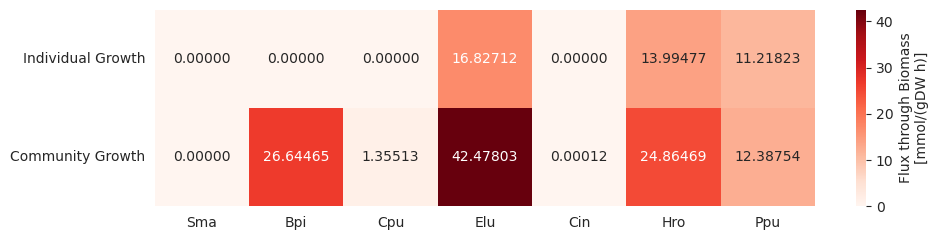

In [28]:
# Combine into 2D array for heatmap
growth_ind = [0 if x is None else x for x in growth_ind]
data = np.array([growth_ind, list(growth_com)])

#bac_names = ["AA1", "AA2", "AA3", "AA4", "AA5", "AA6", "AA7"]
bac_names = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]

# Create a DataFrame for better labeling
df = pd.DataFrame(data,
                  index=["Individual Growth", "Community Growth"],
                  columns=bac_names)

#tree_order = ["Cin", "Ppu", "Sma", "Elu", "Bpi", "Hro", "Cpu"]
#df = df[tree_order]  # Reorder columns



# Plot
plt.figure(figsize=(10, 2.5))
sns.heatmap(df, annot=True, fmt=".5f", cmap="Reds", cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'})
#plt.title("Individual vs Community Growth")
plt.tight_layout()
#plt.show()
plt.savefig("../Figures/growth_values.svg")

In [ ]:
for model in all_models.values():
    growth_val = test_medium(model, medium_mre_m9)
    print(model.id, ": ", growth_val)

In [ ]:
with syncom:
    new = e_to_m(medium_mre_m9)
    syncom.medium = new
    syn_fluxi = pfba(syncom).fluxes


AA2 is able to grow within the community model although it was previously not able to grow on its own (nice!) AA2 needed thiamine to grow. \
AA1 and AA5 are still not growing. \
For AA1 it could be worth a try to change orn__D and orn

In [ ]:
for model in all_models.values():
    growth_val = test_medium(model, med_wo_bz)
    print(model.id, ": ", growth_val)

lets check AA2 within the community

In [ ]:
with syncom:
    change_medium(syncom, medium_mre_m9)
    c7 = pfba(syncom).fluxes

In [ ]:
c7[(c7.index.str.contains('Growth'))
   ]

In [ ]:
c7[(c7.index.str.startswith('EX_')) &
   (c7.index.str.endswith('_AA2')) &
   (c7 < 0)]

In [ ]:
# AA7 secretes thm into medium
c7[(c7.index.str.contains('thm_e')) &
    (c7 > 0)]

In [ ]:
with AA7:
    change_medium(AA7, medium_mre_m9)
    aa7 = pfba(AA7).fluxes

In [ ]:
aa7[(aa7.index.str.contains('thm_e'))]
# AA7 only secretes thm in the community, on its own, it doesnt do that

lets check why the community doesnt need bz in the medium

In [ ]:
with syncom:
    change_medium(syncom, med_wo_bz)
    c7 = pfba(syncom).fluxes

In [ ]:
c7[(c7.index.str.contains('Growth')) ]

In [ ]:
c7[(c7.index.str.contains('_bz_e')) &
    (c7 > 0)]

In [ ]:
c7[(c7.index.str.contains('_bz_e')) &
    (c7 < 0)]

just because we see no growth in AA1 and AA5 doesnt mean they're dead, i think they're just vibing without growth because we still see fluxes

In [ ]:
c7[(c7.index.str.contains('AA5')) &
    (c7 != 0)]

In [ ]:
c7[(c7.index.str.contains('AA1')) &
    (c7 != 0)]

## Ecoplate Substrate Utilisation

[07/04/25 16:48:14] WARNING  solver encountered an error infeasible                                 ]8;id=264500;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=843199;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/04/25 16:48:15] WARNING  solver encountered an error infeasible                                 ]8;id=546213;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=133473;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/04/25 16:48:42] WARNING  solver encountered an error infeasible                                 ]8;id=674727;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=946058;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

[07/04/25 16:48:43] WARNING  solver encountered an error infeasible                                 ]8;id=462926;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py\solution.py]8;;\:]8;id=282932;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/solution.py#206\206]8;;\

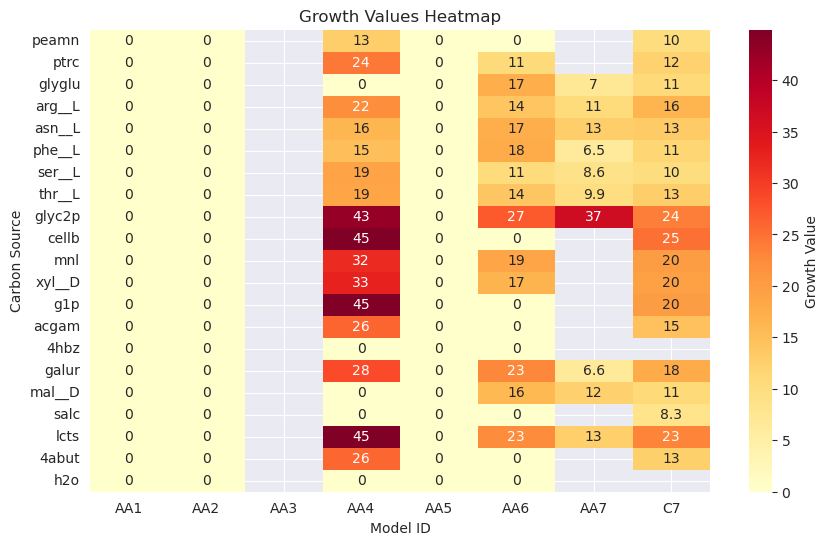

In [35]:
# AA7 is very sensitive to changes the bounds, it needs >500 to grow
create_medium(ecoplate_rxns, m9_rxn, all_models, 1000)

In [ ]:
# all reactions in the M9 have a bound of 1000, only bounds of carbon reactions are modified
# AA7 can grow with carbon sources <500, i.e. especially O2 is limiting (i saw that in other simulations, that o2 ans fructose were the ones with highest flux values)
create_medium(ecoplate_rxns, m9_rxn, all_models, 45, carbon_only=True)

In [ ]:
create_medium(ecoplate_rxns, m9_rxn, all_models, 1000)

In [ ]:
# without benzoate in medium
create_medium(ecoplate_rxns, m9_rxn[:-1], all_models, 1000)

## Aufnahme und Abgabe

In [57]:
def compare_rxn_lists(com_index, single_index, model_id):
    # Convert to sets
    set1 = list(com_index)
    set2 = set(single_index)

    # Cut off the last 5 characters from each ID in list1
    set1 = set([rxn[:-5] for rxn in set1])

    # Reactions in both lists
    shared = set1 & set2  # or set1.intersection(set2)

    # unique reactions
    unique_to_list1 = set1 - set2
    unique_to_list2 = set2 - set1

    #print("Shared reactions:", sorted(shared))
    #print(f"Unique to Community-{model_id}:", sorted(unique_to_list1))
    #print(f"Unique to {model_id}:", sorted(unique_to_list2))

    return shared, unique_to_list1, unique_to_list2

In [127]:
def convert_cooptradeoff_into_fluxes(model, frac=1):

    if hasattr(model, "modification") and model.modification is not None:
        # Custom reset logic (depends on `Community` object's structure)
        model.modification = None  # Example: clearing an attribute


    with model:
        pfba_fluxes = model.cooperative_tradeoff(fluxes=True, pfba=True, fraction=frac).fluxes.transpose()
        df_long = pfba_fluxes.melt(ignore_index=False, var_name='model', value_name='flux')
        df_long = df_long.reset_index()

        df_long['reaction_id'] = np.where(
            df_long['model'] != 'medium',
            df_long['reaction'] + "__" + df_long['model'],
            df_long['reaction'])

        rxns_in_syncom = set(r.id for r in syncom.reactions)
        df_long = df_long[df_long['reaction_id'].isin(rxns_in_syncom)]
        pfba_fluxes = df_long.set_index('reaction_id')['flux']
        return pfba_fluxes

In [115]:
def get_pfba_fluxes(model, medium, frac=1):
    with model:
        change_medium(model, medium)
        try:
            if model.id != "C7":
                pfba_fluxes = pfba(model).fluxes
            else:
                pfba_fluxes = convert_cooptradeoff_into_fluxes(model, frac=frac)
            #pfba_fluxes = pfba(model).fluxes
            return pfba_fluxes
        except Infeasible:
            return None

In [67]:
def get_fluxes_for_heatmap(model, medium, type, c7_all_ex="no"):
    fluxes = get_pfba_fluxes(model, medium)

    if fluxes is None:
        print(model.id)
        return {}

    if type == "uptake":
        filtered_fluxes = fluxes[(fluxes.index.str.startswith('EX_')) &
                                 (fluxes < 0)]
    elif type == "secret":
        filtered_fluxes = fluxes[(fluxes.index.str.startswith('EX_')) &
                                 (fluxes > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    # this decides if we just include medium EX or all EX between the bacteria
    if model.id == "C7" and c7_all_ex == "no":
        filtered_fluxes = filtered_fluxes[(filtered_fluxes.index.str.endswith('_m'))]

    flux_dict = {}
    for rxn_id, flux in filtered_fluxes.items():
        rxn = model.reactions.get_by_id(rxn_id)
        # Exchange reactions should have exactly one metabolite on one side
        met_id = list(rxn.metabolites.keys())[0].name  # us .id or use .name
        flux_dict[met_id] = flux

    #print(flux_dict.keys())
    return flux_dict

In [108]:
def uptake_secret_heatmap(all_models, type, initial_medium=None, c7_all_ex="no"):
    data = {}

    for model_name, model_obj in all_models.items():
        if initial_medium is None:
            medium = minimal_medium(model_obj, 2)
            medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
            flux_dict = get_fluxes_for_heatmap(model_obj, medium, type, c7_all_ex)
        else:
            flux_dict = get_fluxes_for_heatmap(model_obj, initial_medium, type, c7_all_ex)
        data[model_name] = flux_dict  # keys: model names, values: dict of metabolite: flux

    df = pd.DataFrame(data).fillna(0)
    df = df.abs() # absolute values, so even negative fluxes have right colour scale that |-1000| is bigger than 0
    df = df.replace(0, np.nan)

    vmin = 1e-5  # threshold: if all flux values for a metabolite are below, they dont show up in the plot to not screw the color scale too much
    df_filtered = df[df.max(axis=1) >= vmin]

    # Depending on Uptake or Secretion, choose different color scale
    color_map = {"uptake": "Blues", "secret": "Reds"}
    base_cmap_name = color_map[type]

    # Build custom colormap that starts with white
    base = sns.color_palette(base_cmap_name, 256).as_hex()
    custom_colors = ["#ffffff"] + base[1:]  # replace first entry with white
    custom_cmap = LinearSegmentedColormap.from_list(f"{base_cmap_name}_custom", custom_colors)

    #print(df)

    # Plot heatmap
    plt.figure(figsize=(12, len(df_filtered) * 0.4))
    plt.grid(False)

    ax = sns.heatmap(
        df_filtered,
        cmap=custom_cmap,
        norm=LogNorm(vmin=vmin, vmax=df_filtered.max().max()),
        cbar_kws={"label": "Flux (log scale)"},
        mask=df_filtered == 0,  # hide zero-flux cells
        linewidths=0.01,
        linecolor="whitesmoke"
    )

    # Clean up axes and background grid artifacts
    ax.set_facecolor("white")  # fill background of masked cells with white
    sns.despine(left=True, bottom=True)  # remove spines
    ax.tick_params(length=0)  # remove tick marks

    plt.title(f"{type.capitalize()} fluxes across models")
    plt.xlabel("Models")
    plt.ylabel(f"{type.capitalize()} reactions")
    plt.tight_layout()
    #plt.show()

    """ without logarithmic scale
    # Plot heatmap
    plt.figure(figsize=(12, len(df) * 0.4))
    sns.heatmap(
        df,
        cmap=custom_cmap,
        vmin=0,  # ensures white is only used at exactly 0
        vmax=df.max().max(),  # max flux defines the top of the gradient
        linewidths=0.01,
        linecolor="whitesmoke",
        cbar_kws={"label": "Flux"}
    )
    plt.title(f"{type.capitalize()} fluxes across models")
    plt.xlabel("Models")
    plt.ylabel(f"{type.capitalize()} reactions")
    plt.tight_layout()
    plt.show()
    """

AA3


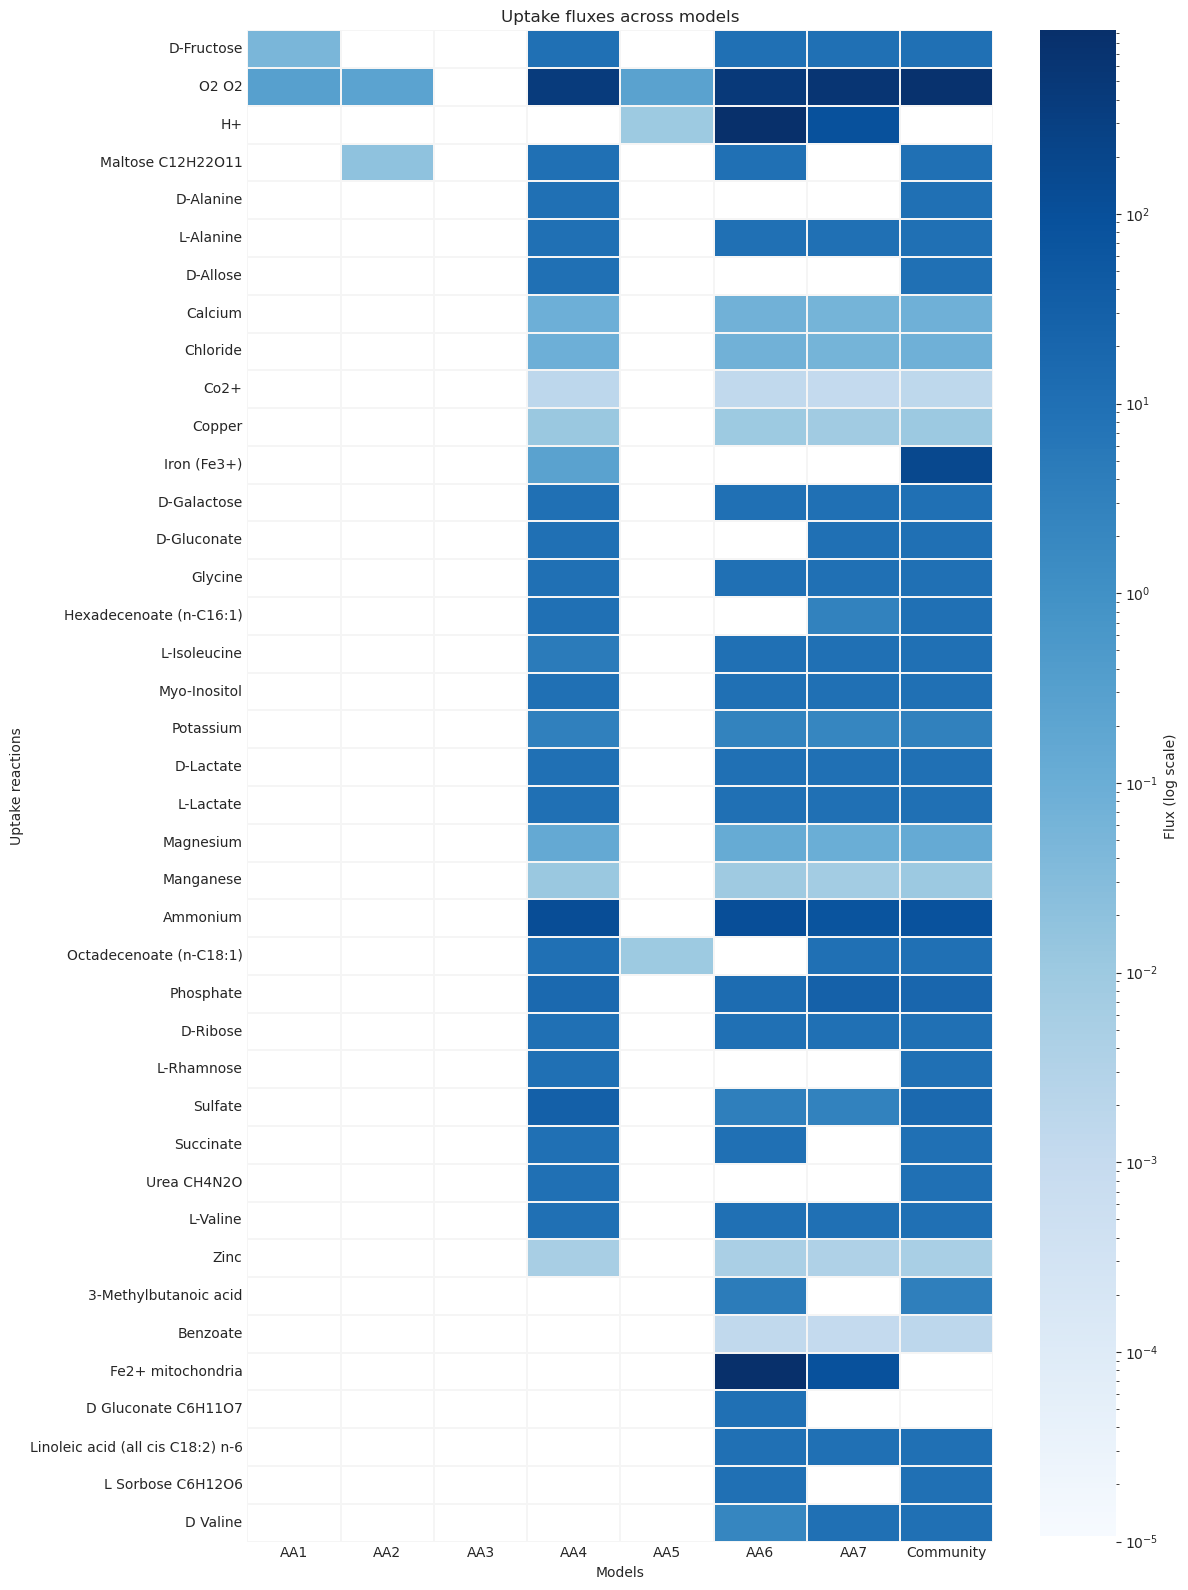

In [110]:
# the code for the community works in a way it only looks at EX reactions into/from the medium and outside and NO EX into/from a model into the medium
uptake_secret_heatmap(all_models, "uptake", medium_combined)

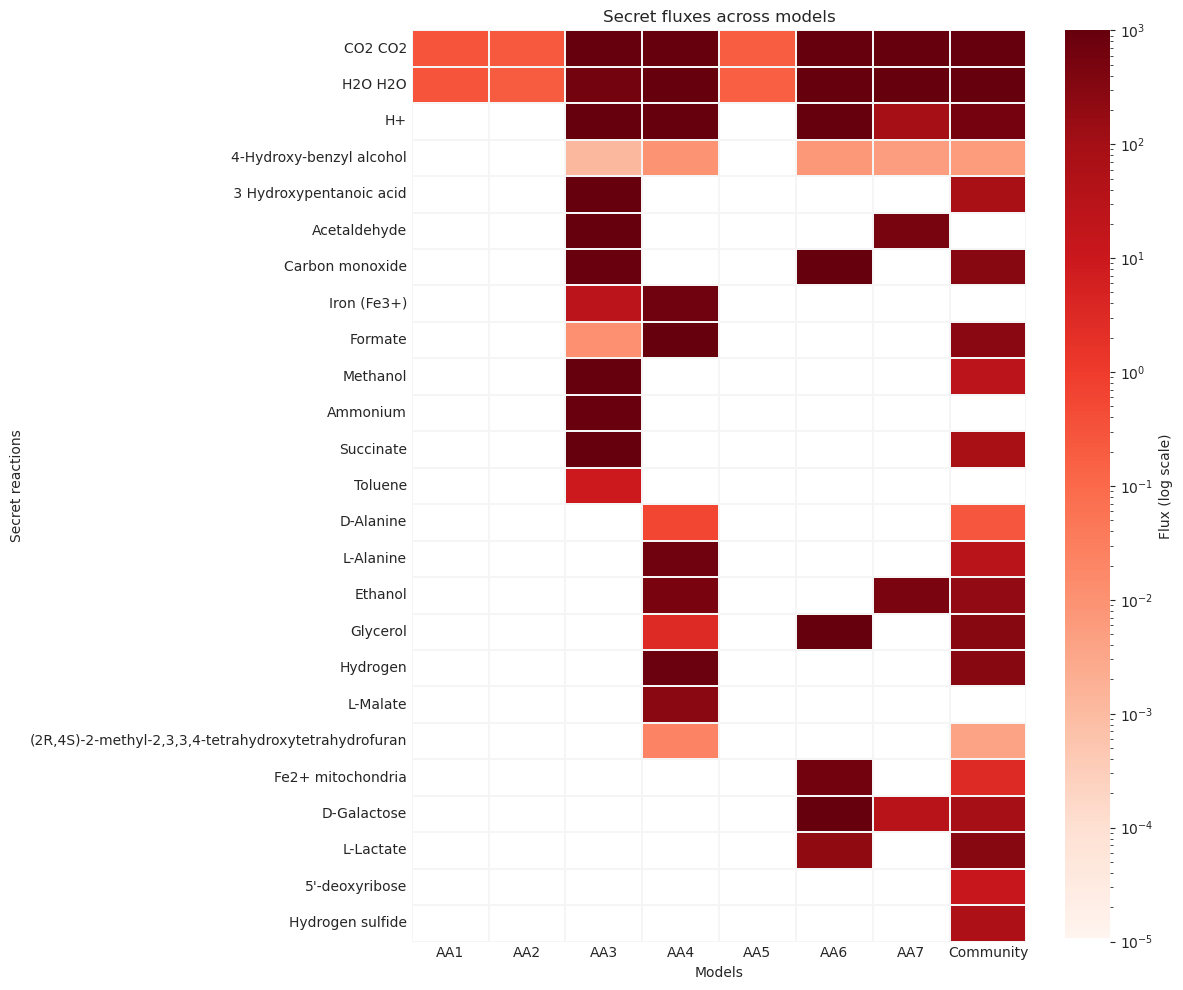

In [109]:
df = uptake_secret_heatmap(all_models, "secret", medium_mre_m9)

it may be interessting to see the metabolic niches of all my bacteria. but because some of them are not able to grow on their own, i would disregard the medium right now and maybe use the minimal medium for each of the bacteria determined by cobrapy.

In [ ]:
uptake_secret_heatmap(all_models, "uptake", c7_all_ex="no")

In [ ]:
uptake_secret_heatmap(all_models, "secret", c7_all_ex="no")

I think the community lacks a bit of uptake because the above plots only check for uptake/secretion into the medium from the outside. all metabolites that are secreted and uptaken by the members are disregarded. however in the paper it is very likely that the would measure that as well because the medium compartment doesnt exist in RL

Get the Uptakes and Secretion Fluxes more in detail; Comparison between individual model and their behaviour in the community

In [111]:
def get_uptake_secrets(model, medium, type):
    syncom_fluxes = get_pfba_fluxes(syncom, medium)
    single_flux = get_pfba_fluxes(model, medium)

    if type == "uptake":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes < 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux < 0)]
    elif type == "secret":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes > 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    shared, unique_to_com, unique_to_single = compare_rxn_lists(com_uptakes.index, single_uptakes.index, model.id)
    return shared, unique_to_com, unique_to_single


In [ ]:
uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared = [], [], [], [], [], []

for model in models.values():
    up_shared, up_unique_to_com, up_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "uptake")
    uptake_single.append(up_unique_to_single)
    uptake_com.append(up_unique_to_com)
    uptake_shared.append(up_shared)

    sec_shared, sec_unique_to_com, sec_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "secret")
    secret_single.append(sec_unique_to_single)
    secret_com.append(sec_unique_to_com)
    secret_shared.append(sec_shared)

# if Infeasible, change the bounds within the Community to 1000, see MICOM creation

In [ ]:
labels = [f"AA{i}" for i in range(1, 8)]  # ['AA1', 'AA2', ..., 'AA7']
df_uptakes_secrets = pd.DataFrame({
    'model': labels,
    'uptake_single': uptake_single,
    'uptake_com': uptake_com,
    'uptake_shared': uptake_shared,
    'secret_single': secret_single,
    'secret_com': secret_com,
    'secret_shared': secret_shared
})

In [ ]:
df_uptakes_secrets

In [ ]:
from itertools import chain
# Flatten two levels: from list of sets to a single iterable of elements
unique_list = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared]))))
uptake_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared]))))
secret_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    secret_single, secret_com, secret_shared]))))
unique_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, secret_single, secret_com]))))

### Uptakes within Community

check within community who produces what for whom

In [116]:
model_ids = [f"AA{i}" for i in range(1,8)]
epsilon = 1e-6

In [185]:
with syncom:
    change_medium(syncom, medium_combined)
    com_fluxes = convert_cooptradeoff_into_fluxes(syncom)
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction_id"})

    com_fluxes["flux"] = com_fluxes["flux"].apply(lambda x: 0 if abs(x) < epsilon else x)

In [177]:
with syncom:
    change_medium(syncom, medium_mre_m9)
    com_fluxes = pfba(syncom).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction_id"})
    com_fluxes["flux"] = com_fluxes["flux"].apply(lambda x: 0 if abs(x) < epsilon else x)

In [186]:
# Convert index to strings explicitly
com_fluxes.index = com_fluxes.index.astype(str)

In [187]:
uptakes = []
secretes = []

for model in model_ids:
    uptake_flux = com_fluxes[
        (com_fluxes['reaction_id'].str.startswith('EX_')) &
        (com_fluxes['reaction_id'].str.endswith(model)) &
        (com_fluxes['flux'] < 0)
    ]
    uptakes.append(uptake_flux)

    secret_flux = com_fluxes[
        (com_fluxes['reaction_id'].str.startswith('EX_')) &
        (com_fluxes['reaction_id'].str.endswith(model)) &
        (com_fluxes['flux'] > 0)
    ]
    secretes.append(secret_flux)


In [188]:
# Step 1: Collect all EX reaction IDs from individual models (without AA suffix)
all_ex_rxns = set()
for model_id in model_ids:
    model = models[model_id]
    ex_rxns = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_") and rxn.id.endswith("_e")]
    all_ex_rxns.update(ex_rxns)

all_ex_rxns = sorted(all_ex_rxns)

# Step 2: Create full IDs like EX_glc__D_e__AA1 to match community flux index
uptake_data = {model_id: [] for model_id in model_ids}
secretion_data = {model_id: [] for model_id in model_ids}

flux_dict = dict(zip(com_fluxes['reaction_id'], com_fluxes['flux']))

for base_rxn_id in all_ex_rxns:
    for model_id in model_ids:
        com_rxn_id = f"{base_rxn_id}__{model_id}"
        flux = flux_dict.get(com_rxn_id, None)

        epsilon = 0.001  # or whatever threshold you consider "effectively zero"
        # Uptake: flux significantly < 0
        if flux is not None and flux < -epsilon:
            uptake_data[model_id].append(flux)
        else:
            uptake_data[model_id].append(None)

        # Secretion: flux significantly > 0
        if flux is not None and flux > epsilon:
            secretion_data[model_id].append(flux)
        else:
            secretion_data[model_id].append(None)


# Step 3: Build DataFrames
uptake_df = pd.DataFrame(uptake_data, index=all_ex_rxns)
uptake_df.index.name = "reaction"

secretion_df = pd.DataFrame(secretion_data, index=all_ex_rxns)
secretion_df.index.name = "reaction"


In [ ]:
def sort_reactions_by_model_presence(df):
    """Sort reactions: first those used by AA1, then AA2, etc."""
    seen = set()
    sorted_reactions = []

    for model_id in df.columns:
        present_reactions = df[df[model_id].notna()].index.tolist()
        new_reactions = [rxn for rxn in present_reactions if rxn not in seen]
        sorted_reactions.extend(new_reactions)
        seen.update(new_reactions)

    return df.loc[sorted_reactions]

def make_zero_white_cmap(base_cmap='Blues', n=256):
    cmap = plt.get_cmap(base_cmap, n)
    colors = cmap(np.linspace(0, 1, n))
    mid = n // 2
    colors[mid] = np.array([1, 1, 1, 1])  # white for zero flux
    return mcolors.ListedColormap(colors)

def clean_ex_reaction_ids(index):
    """Remove EX_ prefix and _e suffix from exchange reaction IDs."""
    return index.str.replace(r"^EX_", "", regex=True).str.replace(r"_e$", "", regex=True)

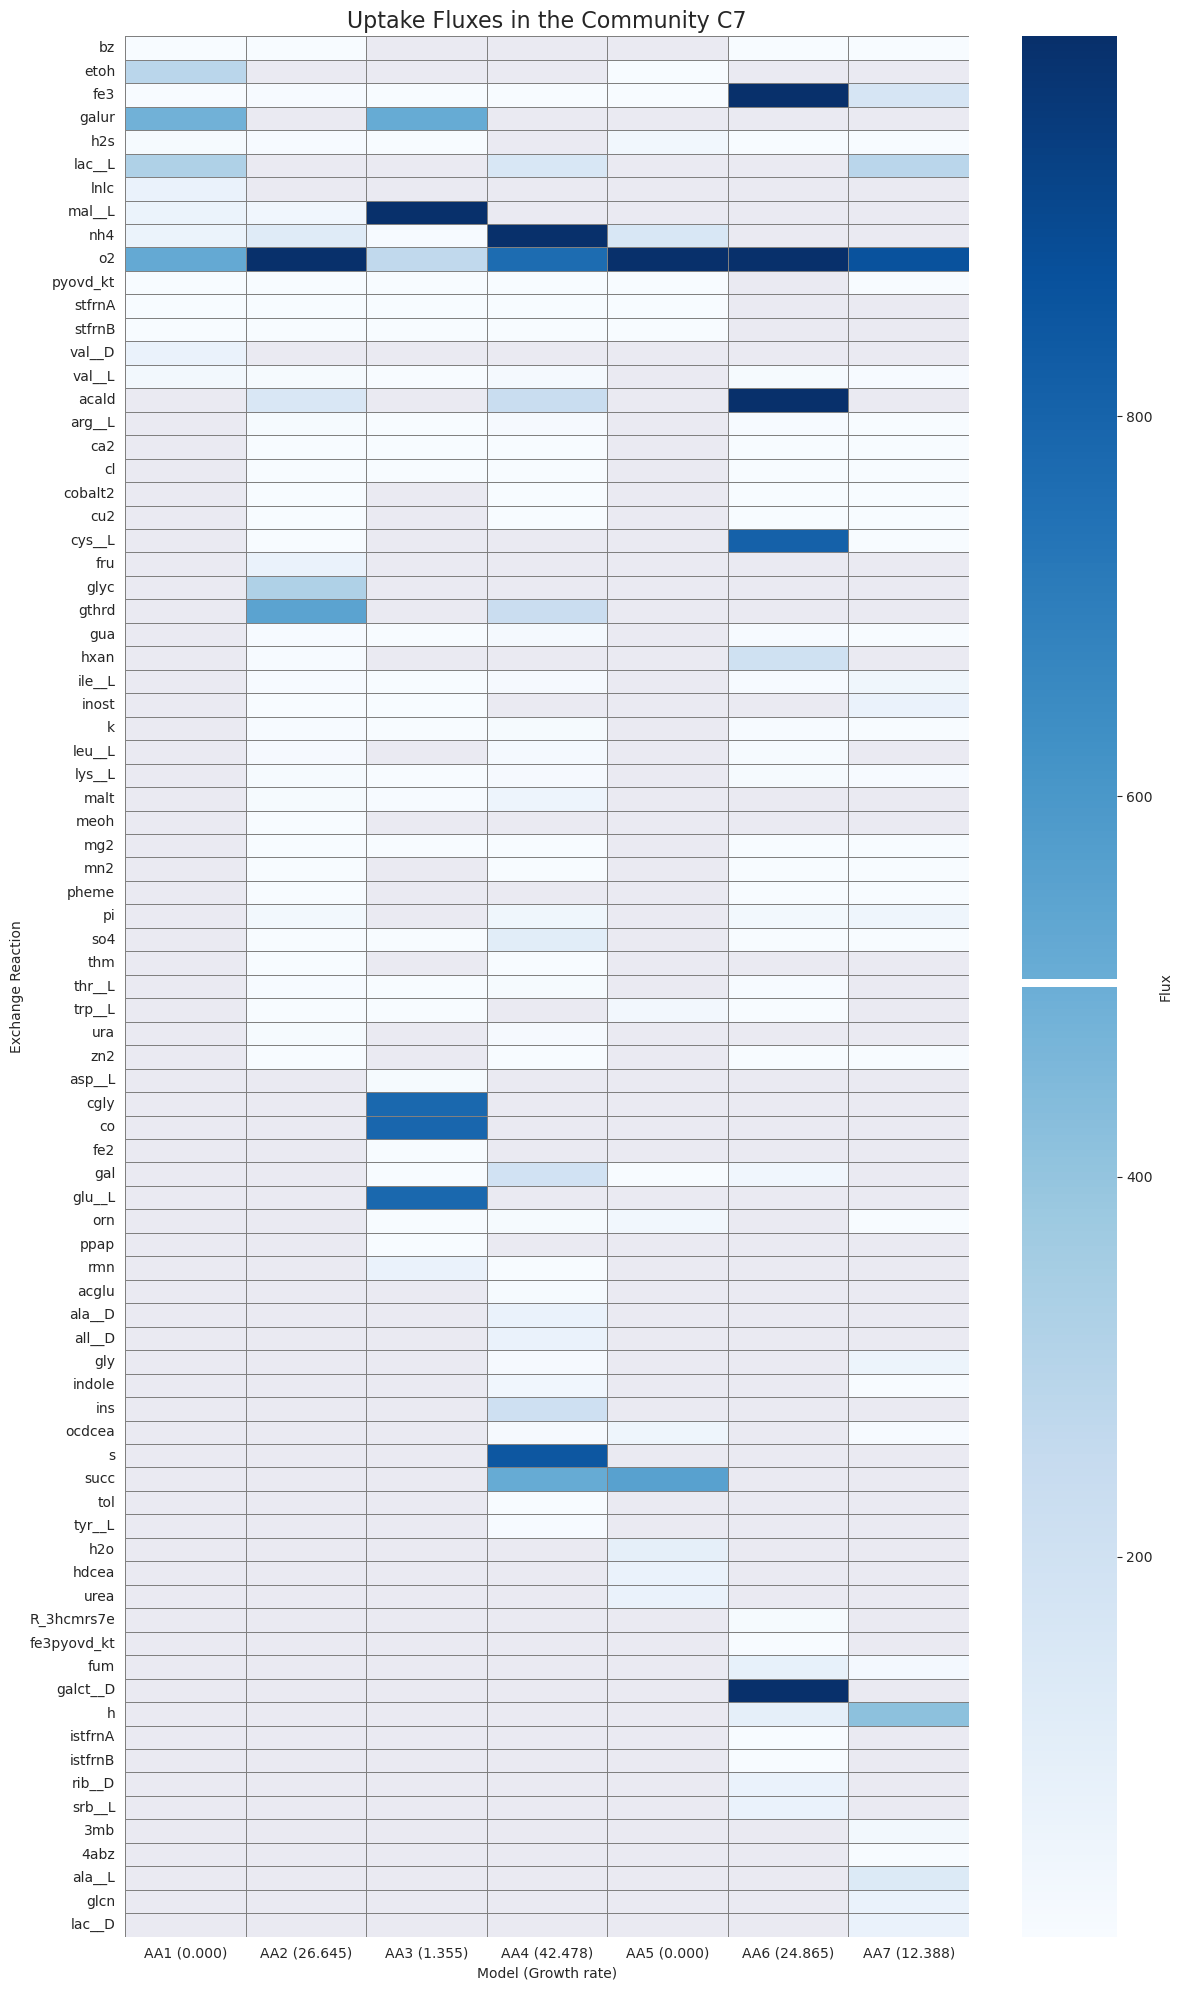

In [189]:
# Prepare data
filtered_uptake = uptake_df.dropna(how='all')
sorted_uptake = sort_reactions_by_model_presence(filtered_uptake)
plot_uptake = sorted_uptake.fillna(0)

# Clean reaction names for y-axis
plot_uptake.index = clean_ex_reaction_ids(plot_uptake.index.to_series())

# Create mask for zero flux (to color white)
mask_uptake = plot_uptake == 0

# Use absolute values so bigger magnitude = darker color
plot_uptake = plot_uptake.abs()

# Create colormap
zero_white_cmap_uptake = make_zero_white_cmap("Blues")

# Extract growth fluxes and format x-axis labels
growth_fluxes = {
    model_id: flux_dict.get(f"Growth__{model_id}", None)
    for model_id in model_ids}

x_labels = [
    f"{model_id} ({growth_fluxes[model_id]:.3f})" if growth_fluxes[model_id] is not None else model_id
    for model_id in plot_uptake.columns]

# Plot uptake heatmap
plt.figure(figsize=(12, 20))
plt.grid(False)
sns.heatmap(plot_uptake, cmap=zero_white_cmap_uptake, mask=mask_uptake,
            linewidths=0.4, linecolor='gray', cbar_kws={'label': 'Flux'},
            xticklabels=x_labels, yticklabels=True)
plt.title("Uptake Fluxes in the Community C7", fontsize=16)
plt.xlabel("Model (Growth rate)")
plt.ylabel("Exchange Reaction")
plt.tight_layout()
plt.show()


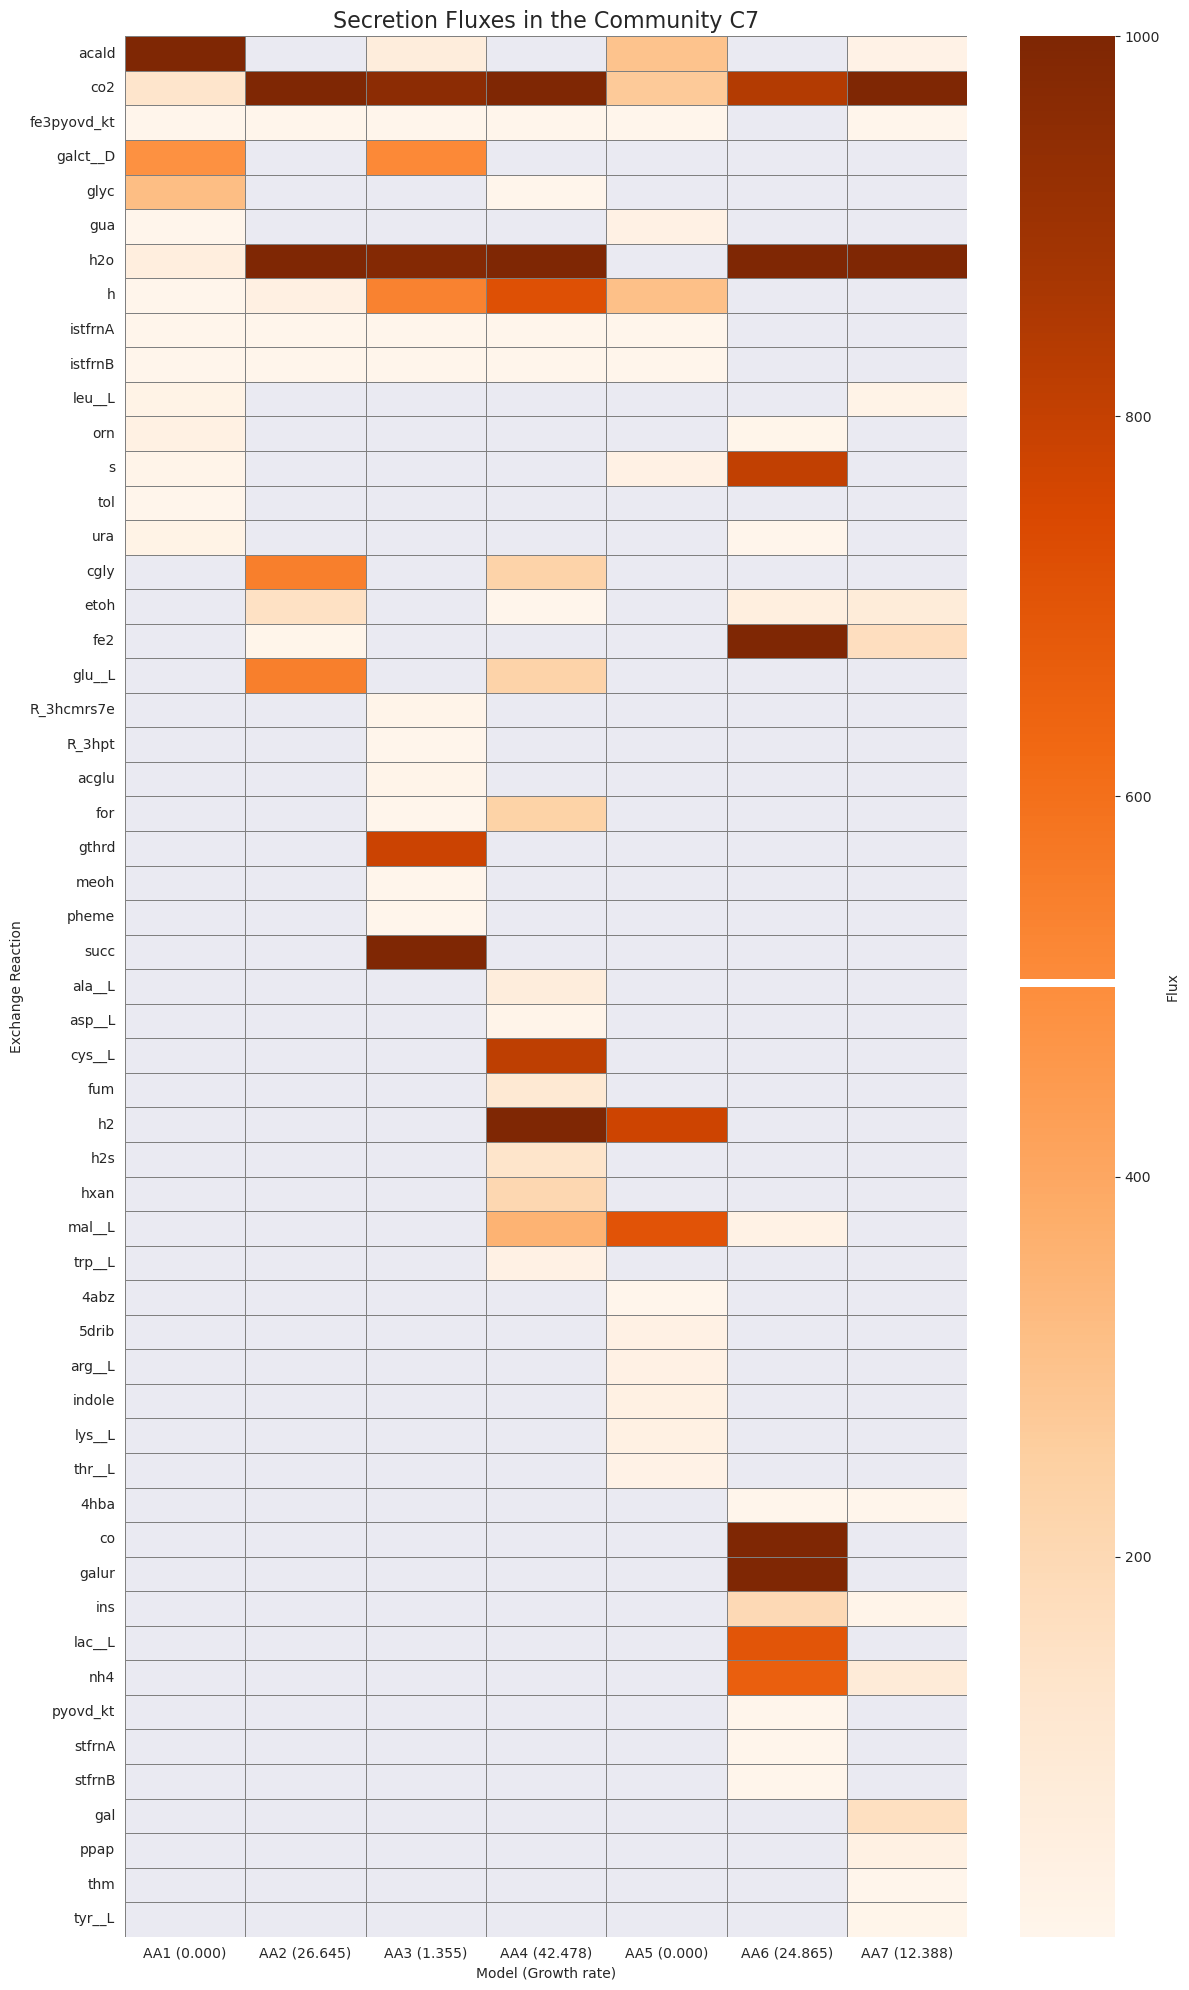

In [190]:
# Prepare data for secretion
filtered_secretion = secretion_df.dropna(how='all')
sorted_secretion = sort_reactions_by_model_presence(filtered_secretion)
plot_secretion = sorted_secretion.fillna(0)

# Clean reaction names for y-axis
plot_secretion.index = clean_ex_reaction_ids(plot_secretion.index.to_series())

# Create mask for zero flux (to color white)
mask_secretion = plot_secretion == 0

# Create colormap for secretion (orange)
zero_white_cmap_secretion = make_zero_white_cmap("Oranges")

# Plot secretion heatmap
plt.figure(figsize=(12, 20))
plt.grid(False)
sns.heatmap(plot_secretion, cmap=zero_white_cmap_secretion, mask=mask_secretion,
            linewidths=0.4, linecolor='gray', cbar_kws={'label': 'Flux'},
            xticklabels=x_labels, yticklabels=True)
plt.title("Secretion Fluxes in the Community C7", fontsize=16)
plt.xlabel("Model (Growth rate)")
plt.ylabel("Exchange Reaction")
plt.tight_layout()
plt.show()


In [ ]:
def visualise_network(model, medium, rxn_list, file_name):
    with model:
        change_medium(model, medium)
        com_fluxes = pfba(model).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction"})
    rxns = set(rxn_list)  # specify list of reactions that you want to visualise, e.g. ["rxn1", "rxn2", ...]
    net = Network(height="700px", width="100%", notebook=True, directed=True)

    for rxn in model.reactions:
        if rxn.id in rxns:

            flux = com_fluxes.loc[com_fluxes["reaction"] == rxn.id, "flux"].values[0]

            # Logarithmic scaling for edge width
            scaling_factor = 5
            if abs(flux) > 1e-6:
                width = min(max(np.log10(abs(flux) + 1) * scaling_factor, 1.5), 15.0)
            else:
                width = 1.0
            print(rxn.id, width)

            # Add reactants → reaction node
            for met in rxn.reactants:
                #net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_node(rxn.id, label=rxn.id, color="red", shape="box")
                #net.add_edge(met.id, rxn.id, color='black')  # reactant edges
            # Add reaction node → products
            for met in rxn.products:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_edge(met.id, rxn.id, color='black', width=width)  # product edges

    # this file is exported and then can be opened and examined your browser)
    net.show(file_name)
    print(f"File saved.")


vis_uptakes = []
for i in range(7):
    vis_uptakes.append(list(uptakes[i]["reaction"]))

vis_uptakes = [item for sublist in vis_uptakes for item in sublist]
len(vis_uptakes)
visualise_network(syncom, med_wo_bz, list(vis_uptakes), "upsis.html")

In [ ]:
import holoviews as hv
from holoviews import opts

hv.extension('bokeh')

# Run pFBA with context
with syncom:
    change_medium(syncom, med_wo_bz)
    solution = pfba(syncom)
    fluxes = solution.fluxes

# Match uptake reactions ending in AA1–AA7 with negative flux
pattern = re.compile(r"^EX_.*_AA[1-7]$")

uptake_rxns = [rxn for rxn in syncom.reactions
               if pattern.match(rxn.id) and fluxes[rxn.id] < -1e-6]

print(f"Found {len(uptake_rxns)} uptake reactions matching criteria.")

def parse_rxn_id(rxn_id):
    core = rxn_id[3:]  # remove EX_
    parts = core.split('_')
    model_abbr = parts[-1]
    metabolite = '_'.join(parts[:-1])
    return metabolite, model_abbr

# Build flux records
records = []
for rxn in uptake_rxns:
    flux = -fluxes[rxn.id]
    metabolite, model = parse_rxn_id(rxn.id)
    records.append({"Metabolite": metabolite, "Model": model, "Flux": flux})

# Create DataFrame
df = pd.DataFrame(records)

# Optional: sort model labels AA1-AA7 numerically for consistent order
df["Model"] = pd.Categorical(df["Model"], categories=sorted(df["Model"].unique(), key=lambda x: int(x[-1])))

# Build Sankey with HoloViews
sankey = hv.Sankey(df, kdims=["Metabolite", "Model"], vdims="Flux")

sankey.opts(
    opts.Sankey(
        title="Uptake Fluxes (into individual models within Community)",
        width=1000,
        height=1500,          # a bit taller helps the eye
        edge_color="Model",
        node_padding=5,
        node_color="Model",
        cmap="Category10",   # one colour per model
        label_position='left',
        show_values=True,
        fontsize={'labels': 9, 'title': 13},
        tools=["hover"]
    )
)


# Spielplatz

checking orn and orn__D but adding a convert reaction in AA1 doesnt change anything i.e. AA1 is still not growing in the community (AA1 needs orn to grow and the other models mostly work with orn instead of orn__D like AA1)

In [ ]:
exes = []
for model in all_models.values():
    exes.extend([(model.id, rxn.id) for rxn in model.reactions if rxn.id.startswith('EX_') and 'orn' in rxn.id])

In [ ]:
exes

In [ ]:
AA1.metabolites.orn__D_e

In [ ]:
AA1.metabolites.orn_e

In [ ]:
from cobra import Reaction

# Step 1: Create the reaction
new_rxn = Reaction('orn_transform')
new_rxn.name = 'Ornithine transformation'
new_rxn.lower_bound = -1000
new_rxn.upper_bound = 1000.0

# Step 2: Get the metabolite objects from the model
met1 = AA1.metabolites.get_by_id('orn__D_e')
met2 = AA1.metabolites.get_by_id('orn_e')

# Step 3: Add metabolites with stoichiometry
new_rxn.add_metabolites({
    met1: -1.0,
    met2: -1.0
})

# Step 4: Add the reaction to the model
AA1.add_reactions([new_rxn])

In [ ]:
AA1.reactions.orn_transform

In [ ]:
growth_val = test_medium(AA1, medium_mre_m9)
print(growth_val)

In [ ]:
rxns = syncom.reactions

In [ ]:
# get minimal media so everybody in communtiy can grow

In [ ]:
from micom.workflows import complete_community_medium

medium = complete_community_medium(manifest, model_folder="../", medium=medium_mre_m9,
                    community_growth=0.1, min_growth=0.01,
                    max_import=10, threads=2)

In [ ]:
og_medium = pd.read_csv("../krumbach_og_medium.csv", sep=";", header=None)

In [ ]:
len(set(og_medium[0]))

In [ ]:
set(og_medium[0])

In [ ]:
from pyvis.network import Network

def visualise_network(model, medium, rxn_list, file_name):
    with model:
        change_medium(model, medium)
        com_fluxes = pfba(model).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction"})
    rxns = set(rxn_list)  # specify list of reactions that you want to visualise, e.g. ["rxn1", "rxn2", ...]
    net = Network(height="700px", width="100%", notebook=True, directed=True)

    for rxn in model.reactions:
        if rxn.id in rxns:

            flux = com_fluxes.loc[com_fluxes["reaction"] == rxn.id, "flux"].values[0]

            # Logarithmic scaling for edge width
            scaling_factor = 5
            if abs(flux) > 1e-6:
                width = min(max(np.log10(abs(flux) + 1) * scaling_factor, 1.5), 15.0)
            else:
                width = 1.0
            print(rxn.id, width)

            # Add reactants → reaction node
            for met in rxn.reactants:
                #net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_node(rxn.id, label=rxn.id, color="red", shape="box")
                #net.add_edge(met.id, rxn.id, color='black')  # reactant edges
            # Add reaction node → products
            for met in rxn.products:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_edge(met.id, rxn.id, color='black', width=width)  # product edges

    # this file is exported and then can be opened and examined your browser)
    net.show(file_name)
    print(f"File saved.")


In [ ]:
vis_uptakes = []
for i in range(7):
    vis_uptakes.append(list(uptakes[i]["reaction"]))

vis_uptakes = [item for sublist in vis_uptakes for item in sublist]

In [ ]:
len(vis_uptakes)

In [ ]:
visualise_network(syncom, med_wo_bz, list(vis_uptakes), "upsis.html")

### Phylo visualisation

In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

tree = Phylo.read("../phyliptree.phy", "newick")

fig = plt.figure(figsize=(12, 8))  # bigger figure helps
ax = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, do_show=False, axes=ax)

plt.tight_layout()  # tries to optimize spacing
plt.show()


In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Read your tree (make sure it's in a supported format)
tree = Phylo.read("../phyliptree.phy", "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()


In [ ]:
from ete3 import Tree

# Load the tree from your .phy file
t = Tree("../phyliptree.phy", format=1)

# Show interactive tree viewer
t.show()
